### Task 10: Add Constant Product Trading interest rate as continuous rebase
* https://cryptorating.eu/whitepapers/Aave/aave-v2-whitepaper.pdf

In [2]:
import os
import copy
import numpy as np
import time
import matplotlib.pyplot as plt
cwd =  os.getcwd().replace("notebooks/test","")
os.chdir(cwd)

from python.dev.event.state.series import StateSeries
from python.dev.event.state import State
from python.dev.event import Deposit
from python.dev.event import Withdraw
from python.dev.token.trade import Convert
from python.dev.cpt import Liquidity
from python.dev.cpt import PriceCurve
from python.dev.cpt import ConstantProductTrade
from python.dev.plot import PlotPriceCurve
from python.dev.token import RebaseToken
from python.dev.math.model import TimeDeltaModel
from python.dev.math.model import TokenDeltaModel
from python.dev.math.model import EventSelectionModel

In [3]:
time0 = time.time()

In [4]:
APY = 0.1
rec = State(Deposit(0,0,0))
rec.init_first_state(time0)
state_series = StateSeries()

for k in range(320):
    delta = TokenDeltaModel(1,10).apply()  
    select = EventSelectionModel().bi_select(0.7)
    t_delta = TimeDeltaModel().apply()
      
    if(select == EventSelectionModel().FIRST): 
        event = Deposit(APY,delta,t_delta)
    else:
        event = Withdraw(APY,delta,t_delta)  

    rec.update_event(event)
    state_series.add_state(rec)
    

principle = state_series.get_principle() 
balance = state_series.get_balance() 
tSamp = state_series.get_tstamp()

In [5]:
for k in range(10):
    type_event = state_series.get_state(k).get_event().type_of()
    print('{}: {} @ {}'.format(k, type_event, tSamp[k]))

0: DEPOSIT @ 2022-04-22 00:20:41.867156
1: DEPOSIT @ 2022-04-22 01:34:48.867156
2: DEPOSIT @ 2022-04-24 03:34:44.867156
3: DEPOSIT @ 2022-04-24 09:11:31.867156
4: WITHDRAW @ 2022-04-25 13:11:45.867156
5: DEPOSIT @ 2022-04-26 11:29:12.867156
6: WITHDRAW @ 2022-04-27 10:24:43.867156
7: DEPOSIT @ 2022-04-28 23:00:17.867156
8: WITHDRAW @ 2022-04-29 05:36:00.867156
9: WITHDRAW @ 2022-05-01 10:41:34.867156


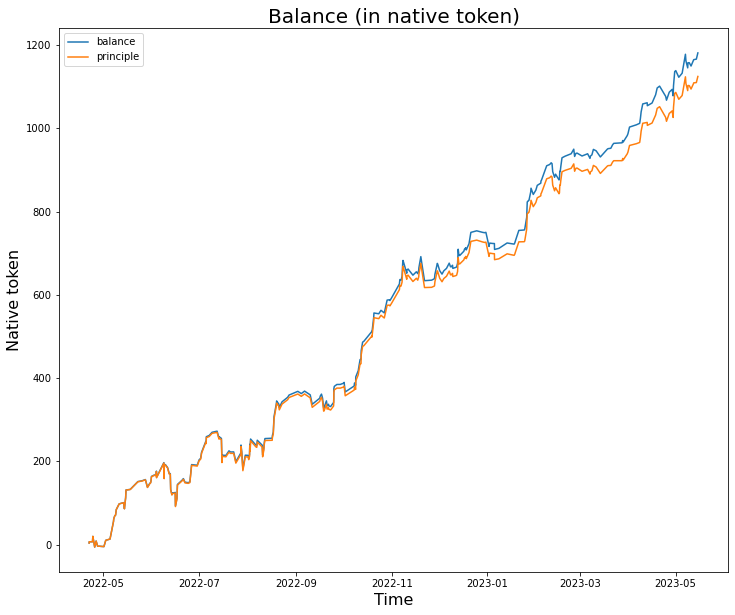

In [6]:
import matplotlib.pyplot as plt

fig, (balance_ax) = plt.subplots(nrows=1, sharex=True, sharey=False, figsize=(12, 10))

balance_ax.plot(tSamp, balance, label='balance') 
balance_ax.plot(tSamp, principle, label='principle') 

balance_ax.set_title("Balance (in native token)", fontsize=20)
balance_ax.set_ylabel("Native token", fontsize=16)
balance_ax.set_xlabel('Time', fontsize=16)
balance_ax.legend()


[Initial] T1: 2723.21 TDT: 6177.91

[Trade 0] T1: 2723.20528 TDT: 6177.90951 L: 4101.67232
[Trade 0] T1_prin: 2723.20528 T1_balance: 2723.20528
[Trade 0] TDT_prin: 6177.90951 TDT_balance: 6177.90951

[Trade 50] T1: 3086.43947 TDT: 5947.69640 L: 4175.57316
[Trade 50] T1_prin: 3039.15232 T1_balance: 3086.43947
[Trade 50] TDT_prin: 5861.96247 TDT_balance: 5947.69640

[Trade 100] T1: 1659.09079 TDT: 7476.41543 L: 4265.73105
[Trade 100] T1_prin: 1584.71474 T1_balance: 1659.09079
[Trade 100] TDT_prin: 7316.40005 TDT_balance: 7476.41543

[Trade 150] T1: 2643.79803 TDT: 6637.37445 L: 4459.29980
[Trade 150] T1_prin: 2537.62412 T1_balance: 2643.79803
[Trade 150] TDT_prin: 6363.49067 TDT_balance: 6637.37445

[Trade 200] T1: 3316.75261 TDT: 6099.55249 L: 4660.43307
[Trade 200] T1_prin: 3169.64388 T1_balance: 3316.75261
[Trade 200] TDT_prin: 5731.47090 TDT_balance: 6099.55249



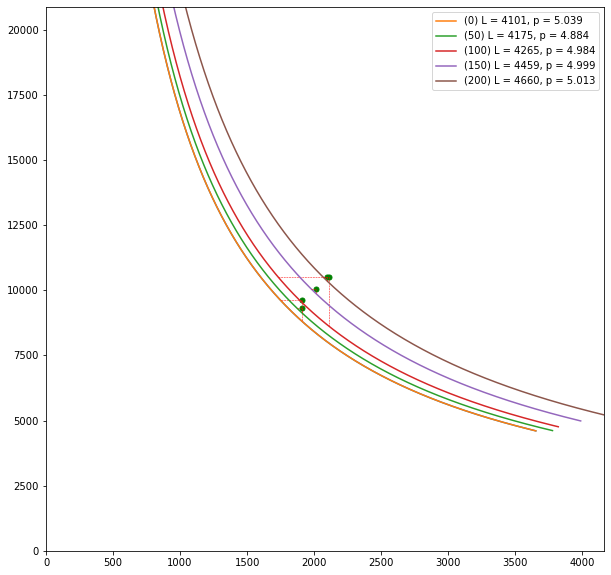

In [7]:
percent = 0.05
N = 250

# Initialize Test Tokens

TYPE_DEPOSIT_TOKEN = 'DEPOSIT'
TYPE_DEBT_TOKEN = 'DEBT'

t_delta = TimeDeltaModel().apply()
depositT1 = TokenDeltaModel(2,2000).apply() 

T1 = RebaseToken(TYPE_DEPOSIT_TOKEN)
t1Address = T1.gen_address()
T1.init_token(time0, t1Address)
T1.add_event(Deposit(APY, depositT1, t_delta, t1Address))

t_delta = TimeDeltaModel().apply()
depositTDT = TokenDeltaModel(2,2000).apply() 

TDT = RebaseToken(TYPE_DEBT_TOKEN)
tdtAddress = TDT.gen_address()
TDT.init_token(time0, tdtAddress)
TDT.add_event(Deposit(APY, depositTDT, t_delta, tdtAddress))

x = T1.get_balance_deposits()
y = TDT.get_balance_deposits()

print('[Initial] T1: {:.2f} TDT: {:.2f}\n'.format(x,y))

# Initialize Liquidity Pool
liq = Liquidity(x,y)
L = liq.calc(); p = np.random.normal(5,0.1,1)[0]
cpt = ConstantProductTrade(L)
pCurve = PriceCurve(L)
plotCurve = PlotPriceCurve(L, cpt, pCurve)
plotCurve.apply(p, None)


for k in range(N):
    # Generate random delta denomenated in Native token, 
    # rebalance respective accounts and convert to T1
    delta_x = TokenDeltaModel(1,100).apply() 
    t_delta = TimeDeltaModel().apply()

    select = EventSelectionModel().bi_select(0.5)
    if(select == EventSelectionModel().FIRST): 
        T1.add_event(Withdraw(APY, delta_x, t_delta, t1Address))
        TDT.add_event(Deposit(APY, delta_x, t_delta, tdtAddress))               
    else:            
        T1.add_event(Deposit(APY, delta_x, t_delta, t1Address))
        TDT.add_event(Withdraw(APY, delta_x, t_delta, tdtAddress))         
    
    TDT_yield = TDT.get_state_series(tdtAddress).get_state(k).get_yield()
    T1_yield = T1.get_state_series(t1Address).get_state(k).get_yield()
    
    liq.add_y(TDT_yield)
    liq.add_x(T1_yield) 
    
    L = liq.update(delta_x); p = np.random.normal(5,0.1,1)[0]
    if (k % int(N/(100*percent)) == 0):
        plotCurve.apply_next(p, L, '({}) L = {}, p = {:.3f}'.format(k, int(L),p))
        plotCurve.plot_trade(p, delta_x, 'r--')
        T1_prin = T1.get_state_series(t1Address).get_state(k).get_principle()
        T1_balance = T1.get_state_series(t1Address).get_state(k).get_balance()

        TDT_prin = TDT.get_state_series(tdtAddress).get_state(k).get_principle()
        TDT_balance = TDT.get_state_series(tdtAddress).get_state(k).get_balance()
            
        print('[Trade {}] T1: {:.5f} TDT: {:.5f} L: {:.5f}'.format(k, x,y,L))
        print('[Trade {}] T1_prin: {:.5f} T1_balance: {:.5f}'.format(k, T1_prin,T1_balance))
        print('[Trade {}] TDT_prin: {:.5f} TDT_balance: {:.5f}\n'.format(k, TDT_prin,TDT_balance))
      
    x = T1.get_balance_deposits()
    y = TDT.get_balance_deposits()



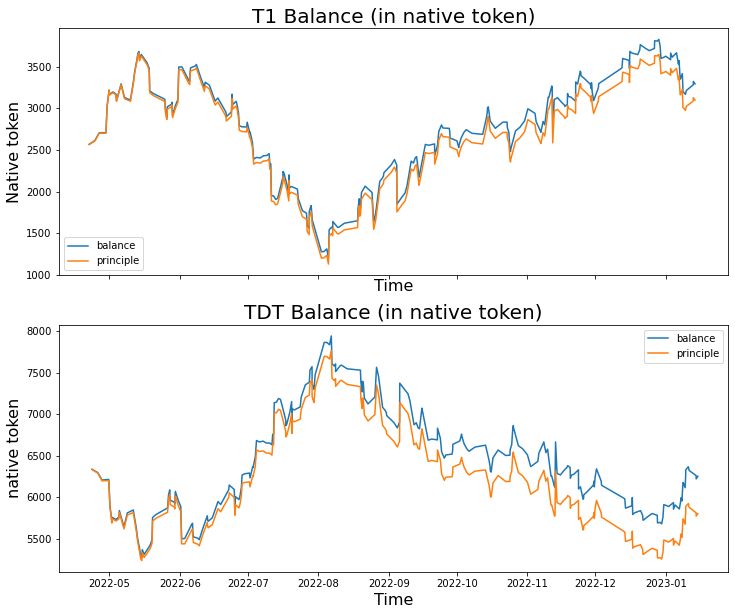

In [8]:
T1_states = T1.get_state_series(t1Address)
principle = T1_states.get_principle() 
balance = T1_states.get_balance() 
tSamp = T1_states.get_tstamp()  

fig, (T1_ax, TDT_ax) = plt.subplots(nrows=2, sharex=True, sharey=False, figsize=(12, 10))

T1_ax.plot(tSamp[1:], balance[1:], label='balance') 
T1_ax.plot(tSamp[1:], principle[1:], label='principle') 
T1_ax.set_title("T1 Balance (in native token)", fontsize=20)
T1_ax.set_ylabel("Native token", fontsize=16)
T1_ax.set_xlabel('Time', fontsize=16)
T1_ax.legend()

TDT_states = TDT.get_state_series(tdtAddress)
principle = TDT_states.get_principle() 
balance = TDT_states.get_balance() 
tSamp = TDT_states.get_tstamp() 

TDT_ax.plot(tSamp[1:], balance[1:], label='balance') 
TDT_ax.plot(tSamp[1:], principle[1:], label='principle') 
TDT_ax.set_title("TDT Balance (in native token)", fontsize=20)
TDT_ax.set_ylabel("native token", fontsize=16)
TDT_ax.set_xlabel('Time', fontsize=16)
TDT_ax.legend()